<a href="https://colab.research.google.com/github/dinianggraini13/SKRIPSI/blob/main/CNN-70%25.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [11]:
! pip install -U imbalanced-learn

In [12]:
from imblearn.over_sampling import SMOTE
from keras.utils import to_categorical

In [3]:
#Machine Learning Libraries
import pandas as pd
import numpy as np
import re
import string
import matplotlib.pyplot as plt
plt.style.use('bmh')
import seaborn as sns
import nltk
from nltk import word_tokenize, WordNetLemmatizer
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import spacy
import matplotlib.pyplot as plt # Visualisasi data
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import pickle

import os
import collections

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [4]:
#Deep Learning Libraries

#For Word2Vec Embedding
from gensim import models
import gensim
from gensim.models import Word2Vec

#For Building Model
import tensorflow as tf
import keras
from keras import regularizers, backend as K
from keras.models import Sequential, load_model
from keras.layers import Dense, Activation, Dropout, Reshape, Flatten, concatenate, Input, Conv1D, GlobalMaxPooling1D, MaxPooling1D, Embedding, BatchNormalization, LSTM, Bidirectional
from tensorflow.keras.utils import to_categorical
from keras.preprocessing import sequence
from keras.preprocessing.text import Tokenizer
from keras.callbacks import EarlyStopping
from keras.preprocessing.sequence import pad_sequences
from keras.models import Model

In [5]:
!pip install mlxtend

In [6]:
from mlxtend.plotting import plot_confusion_matrix

LOAD DATASET

In [7]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [8]:
data = pd.read_csv('hasilreviews_label.csv')

# Membuat DataFrame 'hasilreviews_label' dari data yang diunggah
hasilreviews_label = pd.DataFrame(data, columns=['content', 'label'])

# Cetak beberapa baris pertama dari DataFrame 'hasilreviews_label' untuk memeriksa hasilnya
print(hasilreviews_label.head())


                                             content  label
0  I literally can't use the app. It won't let me...      0
1  The platform has potential, but the app, which...      1
2  Pretty good for a first launch!! Its easy to u...      1
3  Currently, it's very challenging to use. It's ...      0
4  Meh. Not the greatest experience on a Chromebo...      0


In [9]:
data['label'].value_counts()

0    15703
2    14758
1     3008
Name: label, dtype: int64

PREPROCESSING

In [10]:
# Memuat model bahasa spaCy (ganti 'en_core_web_sm' dengan model yang sesuai)
nlp = spacy.load('en_core_web_sm')

# Fungsi untuk tokenization, stopword removal, dan stemming
def preprocess_text(text):
    # Menghapus tanda baca
    translator = str.maketrans('', '', string.punctuation)
    text_no_punct = text.translate(translator)

    # Menghapus karakter non-ASCII (emotikon umumnya non-ASCII)
    text_no_emoticons = re.sub(r'[^\x00-\x7F]+', ' ', text_no_punct)

    # Tokenization
    tokens = word_tokenize(text_no_emoticons.lower())

    # Stopword removal using spaCy
    doc = nlp(" ".join(tokens))
    filtered_tokens = [token.text for token in doc if not token.is_stop]

    # Stemming
    stemmer = PorterStemmer()
    stemmed_tokens = [stemmer.stem(word) for word in filtered_tokens]

    return ' '.join(stemmed_tokens)

# Muat data Anda dan bersihkan teks
data = pd.read_csv("hasilreviews_label.csv")

# Tambahkan kolom untuk hasil preprocessing
data['cleaned_content'] = data['content'].apply(preprocess_text)

# Fungsi untuk tokenisasi dan penghapusan stopwords
def tokenize(text):
    doc = nlp(text)
    return [token.text for token in doc if not token.is_stop]

# Tambahkan kolom 'tokenized_content'
data['tokenized_content'] = data['cleaned_content'].apply(tokenize)

# Tampilkan dataframe data sebelum dan sesudah preprocessing
print("Data Sebelum Preprocessing:")
print(data[['content']])

print("\nData Sesudah Preprocessing:")
print(data[['cleaned_content', 'tokenized_content']])

Data Sebelum Preprocessing:
                                                 content
0      I literally can't use the app. It won't let me...
1      The platform has potential, but the app, which...
2      Pretty good for a first launch!! Its easy to u...
3      Currently, it's very challenging to use. It's ...
4      Meh. Not the greatest experience on a Chromebo...
...                                                  ...
33464             Twitter is better then this copied app
33465                                         Cheap copy
33466  App some Designs copied from Twitter ... I thi...
33467                                                 Ok
33468                  T don't like very so the nice 👍🏻❤

[33469 rows x 1 columns]

Data Sesudah Preprocessing:
                                         cleaned_content  \
0      liter nt use app wo nt let search post look no...   
1      platform potenti app main way use platform mom...   
2      pretti good launch easi use selfexplanatori d 

### **WORDCLOUD**

WordCloud for Label '0':


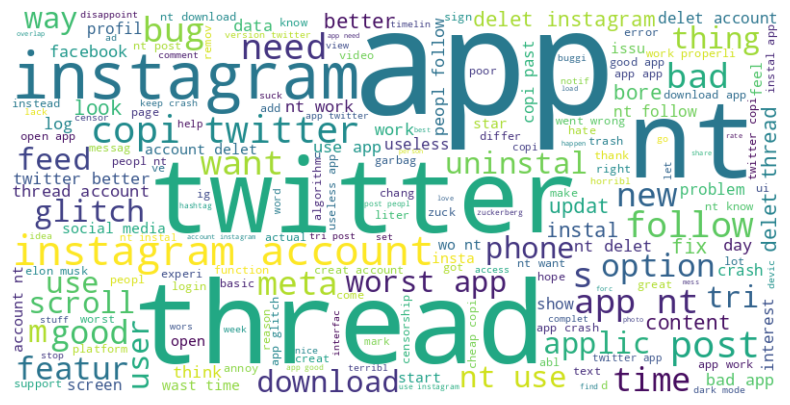

WordCloud for Label '1':


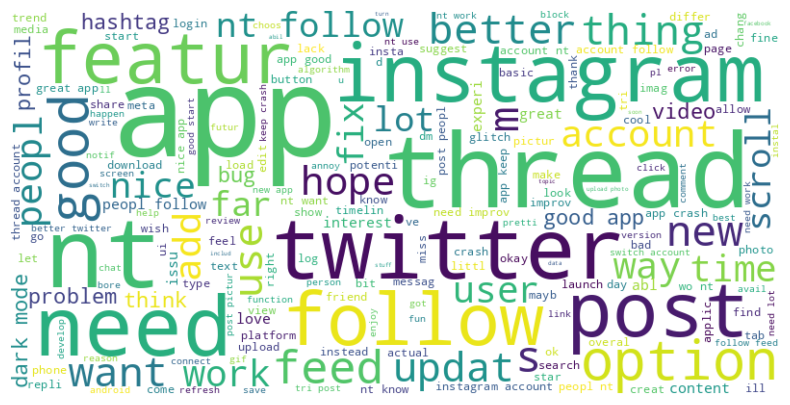

WordCloud for Label '2':


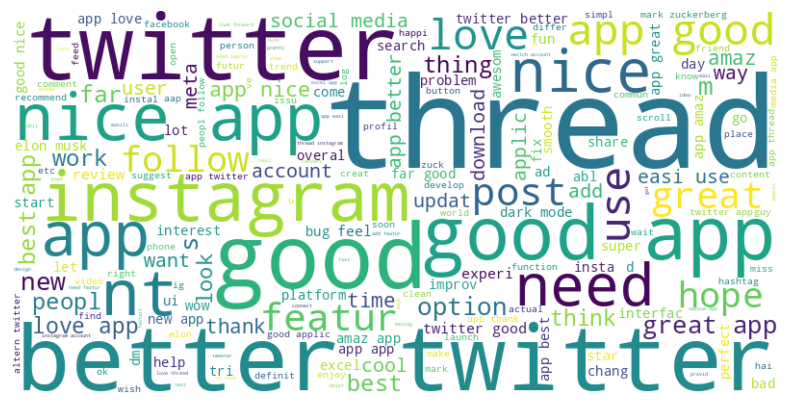

In [13]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Fungsi untuk membuat WordCloud
def generate_wordcloud(text):
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.show()

# Membuat WordCloud untuk setiap label
labels = data['label'].unique()

for label in labels:
    # Menggabungkan teks dari semua review dengan label tertentu
    text_for_label = ' '.join(data[data['label'] == label]['cleaned_content'])

    # Membuat WordCloud
    print(f"WordCloud for Label '{label}':")
    generate_wordcloud(text_for_label)


SPLIT DATA

In [14]:
# Memisahkan data menjadi data sementara (temp_data) dan data pengujian
temp_data, data_test = train_test_split(data, test_size=0.3, random_state=42)

# Memisahkan data sementara menjadi data pelatihan dan data validasi
data_train, data_val = train_test_split(temp_data, test_size=0.25, random_state=42)

print("Data train: %s, Data val: %s, Data test: %s." % (data_train.shape[0], data_val.shape[0], data_test.shape[0]))

Data train: 17571, Data val: 5857, Data test: 10041.


Check Vocab Size and max sentence lenght

In [15]:
#data train
all_training_words = [word for tokens in data_train["tokenized_content"] for word in tokens]
training_sentence_lengths = [len(tokens) for tokens in data_train["tokenized_content"]]
TRAINING_VOCAB = sorted(list(set(all_training_words)))

print("Data train total words : %s , Vocabulary size : %s" % (len(all_training_words), len(TRAINING_VOCAB)))

Data train total words : 123225 , Vocabulary size : 8416


In [16]:
#data val
all_validation_words = [word for tokens in data_val["tokenized_content"] for word in tokens]
validation_sentence_lengths = [len(tokens) for tokens in data_val["tokenized_content"]]
VALIDATION_VOCAB = sorted(list(set(all_validation_words)))

print("Data validation total words: %s, Vocabulary size: %s" % (len(all_validation_words), len(VALIDATION_VOCAB)))


Data validation total words: 39982, Vocabulary size: 4370


In [17]:
#data test
all_test_words = [word for tokens in data_test["tokenized_content"] for word in tokens]
test_sentence_lengths = [len(tokens) for tokens in data_test["tokenized_content"]]
TEST_VOCAB = sorted(list(set(all_test_words)))
print("Data test total words : %s , Vocabulary size : %s" % (len(all_test_words), len(TEST_VOCAB)))

Data test total words : 69745 , Vocabulary size : 6113


# Word Embeddings

In [18]:
from gensim.models import Word2Vec

# Membangun model Word2Vec
model = Word2Vec(data['tokenized_content'], vector_size=100, window=5, min_count=1, sg=0)

# Simpan model Word2Vec
model.save("word2vec_model.model")

In [19]:
vector = model.wv['use']
print(vector)

[-2.46433571e-01  1.62639484e-01  1.08667529e+00 -3.58023167e-01
 -5.83283678e-02 -3.84090573e-01  4.29686964e-01  1.69726491e+00
  1.01299095e-03 -3.82092893e-01 -1.89138100e-01 -1.19719100e+00
 -2.42509186e-01 -5.49917519e-01 -1.89125724e-02 -3.85997832e-01
  7.06764385e-02 -6.79131389e-01 -1.72342919e-02 -1.58606434e+00
 -1.05577834e-01  8.25747013e-01  4.45721418e-01 -2.41928816e-01
 -9.01165307e-01  8.55773091e-01 -7.39056766e-01 -9.19587731e-01
 -4.72088188e-01  3.80772233e-01  2.03832835e-01  2.34557271e-01
 -3.53561118e-02 -8.60417902e-01 -7.42711544e-01  9.73203301e-01
 -6.72055364e-01 -7.36350060e-01 -2.77174115e-01 -9.93533969e-01
  6.72627449e-01 -2.52130210e-01 -6.89426064e-02 -4.32448447e-01
  4.02363658e-01 -3.33469152e-01 -4.45274442e-01 -1.21695288e-01
  1.02839708e-01 -1.85708642e-01  2.48057172e-01 -2.03226626e-01
  2.96796352e-01  2.75518298e-01  1.11808009e-01  2.09524930e-01
  9.12946556e-03  6.85950339e-01 -4.22406226e-01  3.01996410e-01
 -3.97188991e-01 -4.20208

In [20]:
similar_words = model.wv.most_similar(positive=[vector], topn=1)
print(similar_words)


[('use', 1.0)]


In [21]:
#max sequence length
data_train['doc_len'] = data_train['content'].apply(lambda words: len(words.split(' ')))
max_seq_len = np.max(data_train['doc_len'])+1


In [22]:
max_seq_len

108

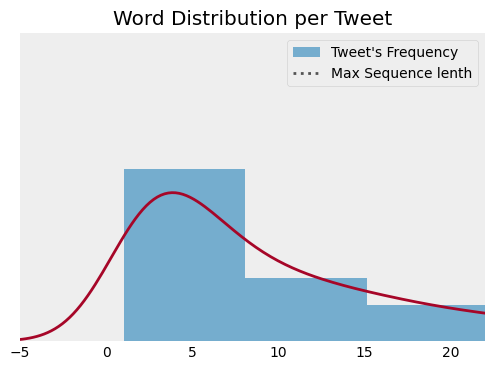

In [23]:
#Plot
fig, ax = plt.subplots(figsize=(6,4))

data_train['doc_len'].plot(kind='hist',
                      density=True,
                      alpha=0.65,
                      bins=15,
                      label="Tweet's Frequency")

data_train['doc_len'].plot(kind='kde', label='')

ax.set_xlim(-5, 22)
ax.set_xlabel("")
ax.set_ylim(0, 0.13)
ax.set_yticks([])
ax.set_ylabel("")
ax.set_title("Word Distribution per Tweet")
ax.grid(False)
ax.axvline(x=max_seq_len, alpha=0.65, color='k', linestyle=':', label='Max Sequence lenth')
ax.tick_params(left = False, bottom = False)
for ax, spine in ax.spines.items():
    spine.set_visible(False)

plt.legend()
plt.show()

Tokenize and Pad sequences

In [24]:
raw_docs_train = data_train['content'].tolist()
raw_docs_val = data_val['content'].tolist()
raw_docs_test = data_test['content'].tolist()

In [25]:
# Tokenizing input data for training
tokenizer = Tokenizer(num_words=len(TRAINING_VOCAB), lower=True, char_level=False)
tokenizer.fit_on_texts(raw_docs_train)
word_seq_train = tokenizer.texts_to_sequences(raw_docs_train)
word_seq_test = tokenizer.texts_to_sequences(raw_docs_test)
word_seq_val = tokenizer.texts_to_sequences(raw_docs_val)

word_index = tokenizer.word_index
print('Dictionary Size: ', len(word_index))


Dictionary Size:  12800


In [26]:
# Tentukan panjang maksimum urutan kata yang sesuai berdasarkan data
max_seq_len = 100  # Contoh: Anda dapat mengatur panjang maksimum menjadi 100

# Lakukan padding pada urutan kata untuk data pelatihan
word_seq_train = sequence.pad_sequences(word_seq_train, maxlen=max_seq_len)

# Lakukan padding pada urutan kata untuk data validasi
word_seq_val = sequence.pad_sequences(word_seq_val, maxlen=max_seq_len)

# Lakukan padding pada urutan kata untuk data pengujian
word_seq_test = sequence.pad_sequences(word_seq_test, maxlen=max_seq_len)


In [27]:
len(word_seq_test)

10041

Train Embeddings Weights

In [28]:
#dimension
EMBEDDING_DIM = 100

In [29]:
train_embedding_weights = np.zeros((len(word_index) + 1, EMBEDDING_DIM))

for word, index in word_index.items():
    if word in model.wv:
        train_embedding_weights[index, :] = model.wv[word]
    else:
        train_embedding_weights[index, :] = np.random.rand(EMBEDDING_DIM)

print(train_embedding_weights.shape)


(12801, 100)


# Hyperparameter CNN

In [30]:
lr = 0.01
batch_size  = 32
num_epochs  = 10
num_filters = 128
filter_size = 2

In [31]:
nb_words = len(word_index)
nb_words

12800

In [32]:
# Kolom label yang berisi nilai 0, 1, 2
one_hot_labels = to_categorical(data_train['label'], num_classes=3)
# train_labels = to_categorical(data_train['label'], num_classes=3)
val_labels = to_categorical(data_val['label'], num_classes=3)
test_labels = to_categorical(data_test['label'], num_classes=3)

In [33]:
train_labels = one_hot_labels

In [34]:
# Inisialisasi objek SMOTE
smote = SMOTE(sampling_strategy='auto', random_state=42)

In [35]:
# Reshape data pelatihan untuk dimasukkan ke SMOTE
word_seq_train_reshaped = word_seq_train.reshape((word_seq_train.shape[0], -1))

# Lakukan oversampling dengan SMOTE
word_seq_train_resampled, one_hot_labels_resampled = smote.fit_resample(word_seq_train_reshaped, one_hot_labels)

# Kembalikan bentuk asli
word_seq_train_resampled = word_seq_train_resampled.reshape((word_seq_train_resampled.shape[0], max_seq_len, -1))

# Update variabel train_labels dengan hasil oversampling
train_labels_resampled = to_categorical(np.argmax(one_hot_labels_resampled, axis=1), num_classes=3)

In [36]:
# Lakukan one-hot encoding pada label untuk digunakan oleh SMOTE
one_hot_labels_before_smote = to_categorical(data_train['label'], num_classes=3)

# Hitung jumlah sampel untuk setiap kelas pada data pelatihan sebelum SMOTE
class_distribution_before_smote = np.sum(one_hot_labels_before_smote, axis=0)

# Tampilkan distribusi kelas sebelum SMOTE
print("Class Distribution Before SMOTE:")
for i, count in enumerate(class_distribution_before_smote):
    print(f"Class {i}: {count} samples")

Class Distribution Before SMOTE:
Class 0: 8237.0 samples
Class 1: 1594.0 samples
Class 2: 7740.0 samples


In [37]:
# Hitung jumlah sampel untuk setiap kelas pada data pelatihan setelah SMOTE
class_distribution_after_smote = np.sum(one_hot_labels_resampled, axis=0)

# Cetak distribusi kelas
print("Class Distribution After SMOTE:")
for i, count in enumerate(class_distribution_after_smote):
    print(f"Class {i}: {count} samples")


Class Distribution After SMOTE:
Class 0: 8237 samples
Class 1: 8237 samples
Class 2: 8237 samples


In [38]:
#early stopping for avoid overfitting model
#early_stopping = EarlyStopping(monitor='val_loss',
                               #min_delta=0.01,
                               #patience=3,
                               #verbose=1)

#callbacks_list = [early_stopping]

# Building Model CNN

In [39]:
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Embedding, Conv1D, MaxPooling1D, GlobalMaxPooling1D, Dense, Dropout
from keras.optimizers import Adam
from keras.preprocessing import sequence
from keras.utils import to_categorical
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score
from keras.callbacks import ModelCheckpoint, Callback


In [40]:
num_classes=3

model = Sequential(name='model')

model.add(Embedding(nb_words+1, EMBEDDING_DIM,
                    weights=[train_embedding_weights],
                    input_length=max_seq_len,
                    trainable=False))

model.add(Conv1D(num_filters, filter_size, activation='relu', padding='same'))
model.add(MaxPooling1D(2))
model.add(Dropout(0.5))

model.add(Conv1D(num_filters, filter_size, activation='relu', padding='same'))
model.add(MaxPooling1D(2))
model.add(Dropout(0.5))

model.add(GlobalMaxPooling1D())

model.add(Dense(64, activation='relu', kernel_regularizer=regularizers.l2(1e-4)))
model.add(Dense(num_classes, activation='softmax'))

adam = Adam(lr=lr)
model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])
model.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 100)          1280100   
                                                                 
 conv1d (Conv1D)             (None, 100, 128)          25728     
                                                                 
 max_pooling1d (MaxPooling1  (None, 50, 128)           0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 50, 128)           0         
                                                                 
 conv1d_1 (Conv1D)           (None, 50, 128)           32896     
                                                                 
 max_pooling1d_1 (MaxPoolin  (None, 25, 128)           0         
 g1D)                                                        

In [41]:
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score
import numpy as np
from keras.callbacks import ModelCheckpoint, Callback

# Tentukan path untuk menyimpan model terbaik
checkpoint_path = 'best_model.h5'  # Ganti dengan format Keras yang direkomendasikan

# Callback untuk menyimpan model terbaik berdasarkan akurasi pada data validasi
checkpoint_callback = ModelCheckpoint(checkpoint_path, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

# Callback untuk evaluasi
class EvaluateOnEpochEnd(Callback):
    def __init__(self, model, word_seq_val, val_labels, word_seq_test, test_labels, num_epochs):
        self.model = model
        self.word_seq_val = word_seq_val
        self.val_labels = val_labels
        self.word_seq_test = word_seq_test
        self.test_labels = test_labels
        self.num_epochs = num_epochs

    def on_epoch_end(self, epoch, logs=None):
        # Evaluasi model pada data validasi
        val_loss, val_accuracy = self.model.evaluate(self.word_seq_val, self.val_labels, verbose=0)
        val_predictions = self.model.predict(self.word_seq_val)
        val_predictions = np.argmax(val_predictions, axis=1)
        val_true_labels = np.argmax(self.val_labels, axis=1)

        # Evaluasi model pada data tes
        test_loss, test_accuracy = self.model.evaluate(self.word_seq_test, self.test_labels, verbose=0)
        test_predictions = self.model.predict(self.word_seq_test)
        test_predictions = np.argmax(test_predictions, axis=1)
        test_true_labels = np.argmax(self.test_labels, axis=1)

        # Tampilkan metrik evaluasi
        print(f"\nEpoch {epoch + 1}/{self.num_epochs}")
        print(f"Validation loss: {val_loss:.4f}")
        print(f"F1 Score: {f1_score(val_true_labels, val_predictions, average='weighted'):.4f}")
        print(f"Precision Score: {precision_score(val_true_labels, val_predictions, average='weighted'):.4f}")
        print(f"Recall Score: {recall_score(val_true_labels, val_predictions, average='weighted'):.4f}")
        print(f"Accuracy Score: {accuracy_score(val_true_labels, val_predictions):.4f}")
        print(f"Test loss: {test_loss:.4f}")
        print(f"Test F1 Score: {f1_score(test_true_labels, test_predictions, average='weighted'):.4f}")
        print(f"Test Precision Score: {precision_score(test_true_labels, test_predictions, average='weighted'):.4f}")
        print(f"Test Recall Score: {recall_score(test_true_labels, test_predictions, average='weighted'):.4f}")
        print(f"Test Accuracy Score: {accuracy_score(test_true_labels, test_predictions):.4f}")

# Inisialisasi list untuk menyimpan metrik-metrik
train_losses = []
val_losses = []
test_losses = []  # Tambahkan list untuk loss pada data tes
train_f1_scores = []
val_f1_scores = []
test_f1_scores = []  # Tambahkan list untuk F1 Score pada data tes
train_precisions = []
val_precisions = []
test_precisions = []  # Tambahkan list untuk Precision Score pada data tes
train_recalls = []
val_recalls = []
test_recalls = []  # Tambahkan list untuk Recall Score pada data tes
train_accuracies = []
val_accuracies = []
test_accuracies = []  # Tambahkan list untuk Accuracy Score pada data tes

# Pelatihan model
for epoch in range(num_epochs):
    print(f"Epoch {epoch + 1}/{num_epochs}")
    hist = model.fit(word_seq_train_resampled,
                     train_labels_resampled,
                     batch_size=batch_size,
                     epochs=1,  # Pelatihan hanya 1 epoch
                     validation_data=(word_seq_val, val_labels),  # Gunakan data validasi yang sesungguhnya
                     shuffle=True,
                     verbose=2,
                     callbacks=[checkpoint_callback, EvaluateOnEpochEnd(model, word_seq_val, val_labels, word_seq_test, test_labels, num_epochs)])  # Tambahkan callback ke sini

    # Simpan loss pada data pelatihan
    train_losses.append(hist.history['loss'][0])

    # Evaluasi model pada data validasi
    val_loss, val_accuracy = model.evaluate(word_seq_val, val_labels, verbose=0)
    val_predictions = model.predict(word_seq_val)
    val_predictions = np.argmax(val_predictions, axis=1)
    val_true_labels = np.argmax(val_labels, axis=1)

    # Simpan metrik evaluasi pada data validasi
    val_losses.append(val_loss)
    val_f1 = f1_score(val_true_labels, val_predictions, average="weighted")
    val_precision = precision_score(val_true_labels, val_predictions, average="weighted", zero_division=1)
    val_recall = recall_score(val_true_labels, val_predictions, average="weighted")
    val_accuracy = accuracy_score(val_true_labels, val_predictions)

    # Simpan metrik evaluasi pada data validasi
    val_f1_scores.append(val_f1)
    val_precisions.append(val_precision)
    val_recalls.append(val_recall)
    val_accuracies.append(val_accuracy)

    # Evaluasi model pada data tes
    test_loss, test_accuracy = model.evaluate(word_seq_test, test_labels, verbose=0)
    test_predictions = model.predict(word_seq_test)
    test_predictions = np.argmax(test_predictions, axis=1)
    test_true_labels = np.argmax(test_labels, axis=1)

    # Simpan loss dan metrik evaluasi pada data tes
    test_losses.append(test_loss)
    test_f1 = f1_score(test_true_labels, test_predictions, average="weighted")
    test_precision = precision_score(test_true_labels, test_predictions, average="weighted")
    test_recall = recall_score(test_true_labels, test_predictions, average="weighted")
    test_accuracy = accuracy_score(test_true_labels, test_predictions)

    # Simpan metrik evaluasi pada data tes
    test_f1_scores.append(test_f1)
    test_precisions.append(test_precision)
    test_recalls.append(test_recall)
    test_accuracies.append(test_accuracy)


Epoch 1/10

Epoch 1: val_accuracy improved from -inf to 0.62028, saving model to best_model.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


314/314 [==============================] - 7s 22ms/step

Epoch 1/10
Validation loss: 0.8837
F1 Score: 0.6393
Precision Score: 0.7105
Recall Score: 0.6203
Accuracy Score: 0.6203
Test loss: 0.8844
Test F1 Score: 0.6374
Test Precision Score: 0.7065
Test Recall Score: 0.6183
Test Accuracy Score: 0.6183
773/773 - 72s - loss: 0.9620 - accuracy: 0.5385 - val_loss: 0.8837 - val_accuracy: 0.6203 - 72s/epoch - 93ms/step
314/314 [==============================] - 4s 12ms/step
Epoch 2/10

Epoch 1: val_accuracy improved from 0.62028 to 0.66860, saving model to best_model.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


314/314 [==============================] - 3s 9ms/step

Epoch 1/10
Validation loss: 0.7901
F1 Score: 0.6912
Precision Score: 0.7289
Recall Score: 0.6686
Accuracy Score: 0.6686
Test loss: 0.7990
Test F1 Score: 0.6853
Test Precision Score: 0.7233
Test Recall Score: 0.6605
Test Accuracy Score: 0.6605
773/773 - 37s - loss: 0.8722 - accuracy: 0.5997 - val_loss: 0.7901 - val_accuracy: 0.6686 - 37s/epoch - 48ms/step
314/314 [==============================] - 3s 10ms/step
Epoch 3/10

Epoch 1: val_accuracy improved from 0.66860 to 0.68619, saving model to best_model.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


314/314 [==============================] - 3s 10ms/step

Epoch 1/10
Validation loss: 0.7751
F1 Score: 0.6867
Precision Score: 0.7036
Recall Score: 0.6862
Accuracy Score: 0.6862
Test loss: 0.7811
Test F1 Score: 0.6892
Test Precision Score: 0.7041
Test Recall Score: 0.6894
Test Accuracy Score: 0.6894
773/773 - 41s - loss: 0.8216 - accuracy: 0.6382 - val_loss: 0.7751 - val_accuracy: 0.6862 - 41s/epoch - 53ms/step
314/314 [==============================] - 3s 9ms/step
Epoch 4/10

Epoch 1: val_accuracy improved from 0.68619 to 0.70121, saving model to best_model.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


314/314 [==============================] - 3s 9ms/step

Epoch 1/10
Validation loss: 0.7719
F1 Score: 0.7125
Precision Score: 0.7272
Recall Score: 0.7012
Accuracy Score: 0.7012
Test loss: 0.7775
Test F1 Score: 0.7124
Test Precision Score: 0.7270
Test Recall Score: 0.7009
Test Accuracy Score: 0.7009
773/773 - 38s - loss: 0.7907 - accuracy: 0.6556 - val_loss: 0.7719 - val_accuracy: 0.7012 - 38s/epoch - 50ms/step
314/314 [==============================] - 3s 9ms/step
Epoch 5/10

Epoch 1: val_accuracy improved from 0.70121 to 0.70702, saving model to best_model.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


314/314 [==============================] - 3s 9ms/step

Epoch 1/10
Validation loss: 0.7493
F1 Score: 0.7203
Precision Score: 0.7366
Recall Score: 0.7070
Accuracy Score: 0.7070
Test loss: 0.7575
Test F1 Score: 0.7167
Test Precision Score: 0.7339
Test Recall Score: 0.7024
Test Accuracy Score: 0.7024
773/773 - 38s - loss: 0.7679 - accuracy: 0.6722 - val_loss: 0.7493 - val_accuracy: 0.7070 - 38s/epoch - 50ms/step
314/314 [==============================] - 3s 9ms/step
Epoch 6/10

Epoch 1: val_accuracy improved from 0.70702 to 0.73280, saving model to best_model.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


314/314 [==============================] - 3s 10ms/step

Epoch 1/10
Validation loss: 0.7317
F1 Score: 0.7283
Precision Score: 0.7245
Recall Score: 0.7328
Accuracy Score: 0.7328
Test loss: 0.7400
Test F1 Score: 0.7228
Test Precision Score: 0.7192
Test Recall Score: 0.7276
Test Accuracy Score: 0.7276
773/773 - 38s - loss: 0.7522 - accuracy: 0.6778 - val_loss: 0.7317 - val_accuracy: 0.7328 - 38s/epoch - 49ms/step
314/314 [==============================] - 3s 9ms/step
Epoch 7/10

Epoch 1: val_accuracy did not improve from 0.73280
314/314 [==============================] - 4s 12ms/step

Epoch 1/10
Validation loss: 0.7722
F1 Score: 0.7083
Precision Score: 0.7457
Recall Score: 0.6816
Accuracy Score: 0.6816
Test loss: 0.7774
Test F1 Score: 0.7133
Test Precision Score: 0.7530
Test Recall Score: 0.6855
Test Accuracy Score: 0.6855
773/773 - 38s - loss: 0.7412 - accuracy: 0.6863 - val_loss: 0.7722 - val_accuracy: 0.6816 - 38s/epoch - 49ms/step
314/314 [==============================] - 3s 9ms/step

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


314/314 [==============================] - 4s 14ms/step

Epoch 1/10
Validation loss: 0.6986
F1 Score: 0.7268
Precision Score: 0.7178
Recall Score: 0.7403
Accuracy Score: 0.7403
Test loss: 0.6995
Test F1 Score: 0.7304
Test Precision Score: 0.7224
Test Recall Score: 0.7421
Test Accuracy Score: 0.7421
773/773 - 40s - loss: 0.7254 - accuracy: 0.6977 - val_loss: 0.6986 - val_accuracy: 0.7403 - 40s/epoch - 52ms/step
314/314 [==============================] - 3s 9ms/step
Epoch 9/10

Epoch 1: val_accuracy did not improve from 0.74031
314/314 [==============================] - 4s 13ms/step

Epoch 1/10
Validation loss: 0.7344
F1 Score: 0.7250
Precision Score: 0.7306
Recall Score: 0.7198
Accuracy Score: 0.7198
Test loss: 0.7398
Test F1 Score: 0.7274
Test Precision Score: 0.7347
Test Recall Score: 0.7207
Test Accuracy Score: 0.7207
773/773 - 39s - loss: 0.7182 - accuracy: 0.6983 - val_loss: 0.7344 - val_accuracy: 0.7198 - 39s/epoch - 51ms/step
314/314 [==============================] - 3s 9ms/step

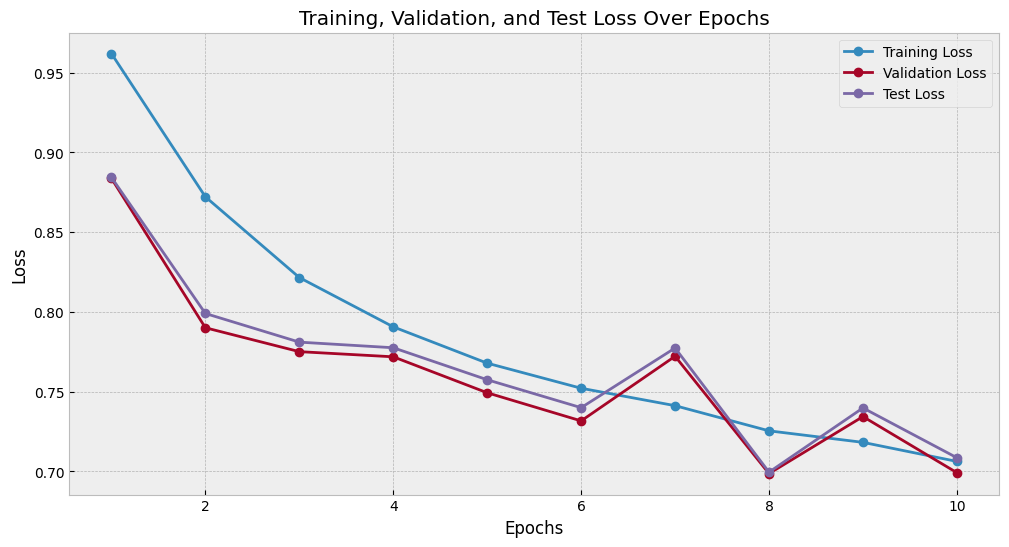

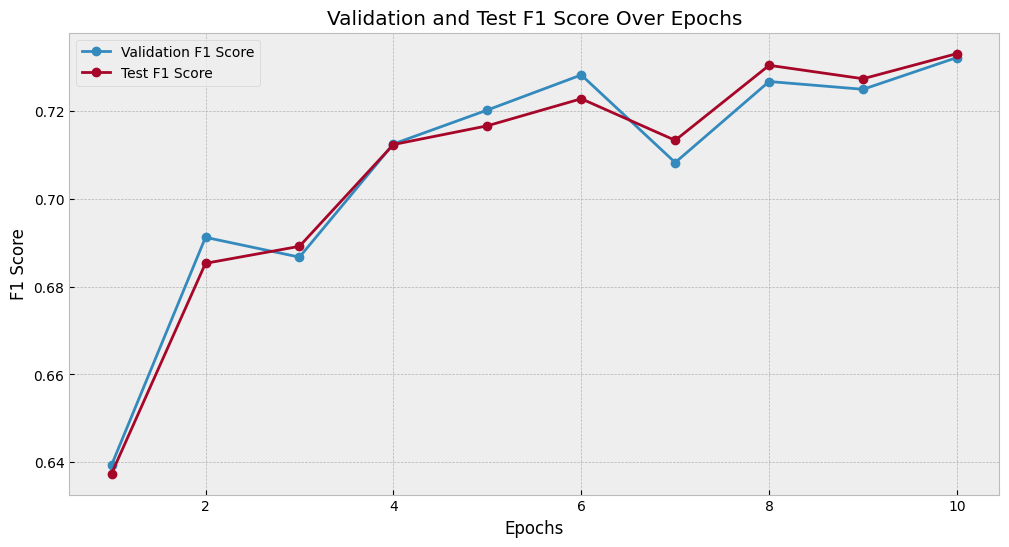

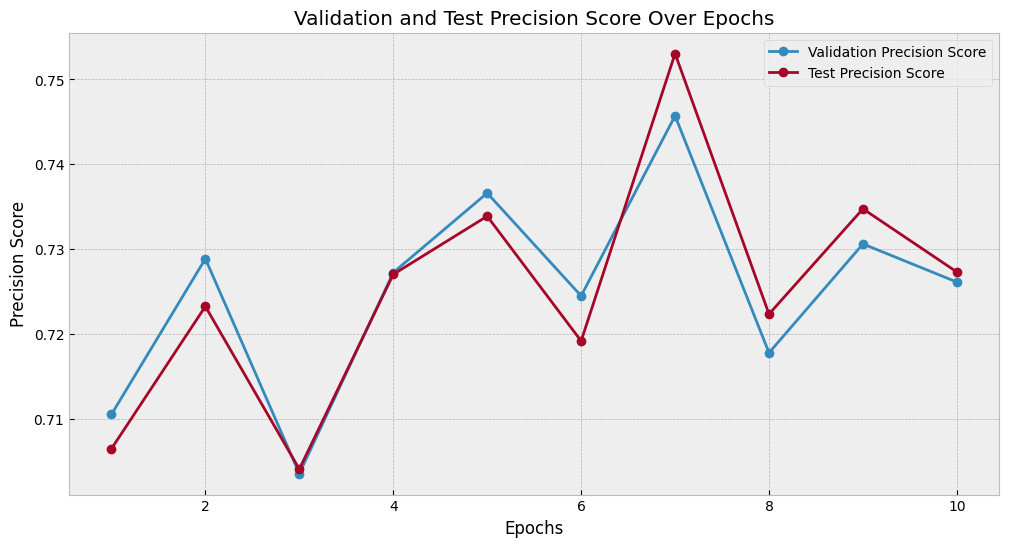

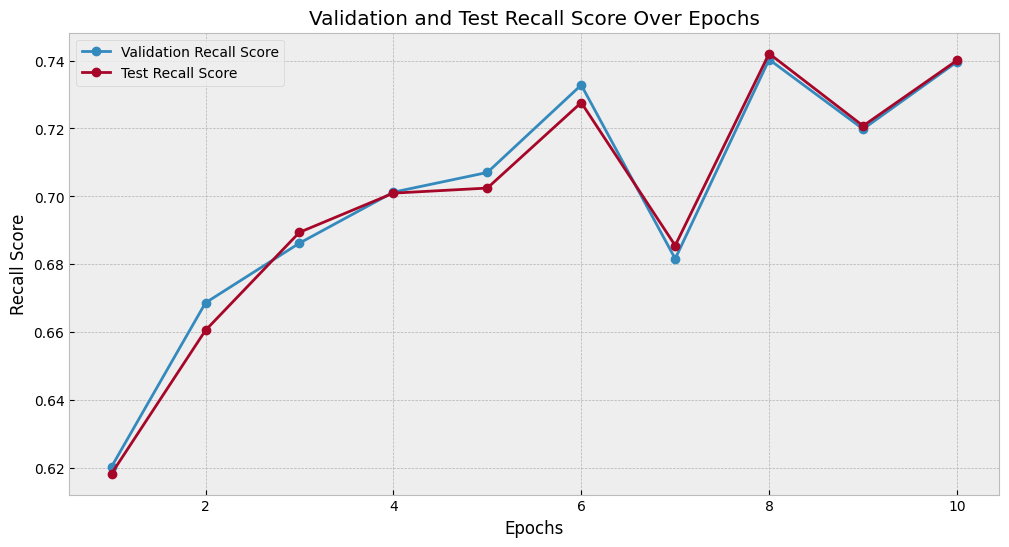

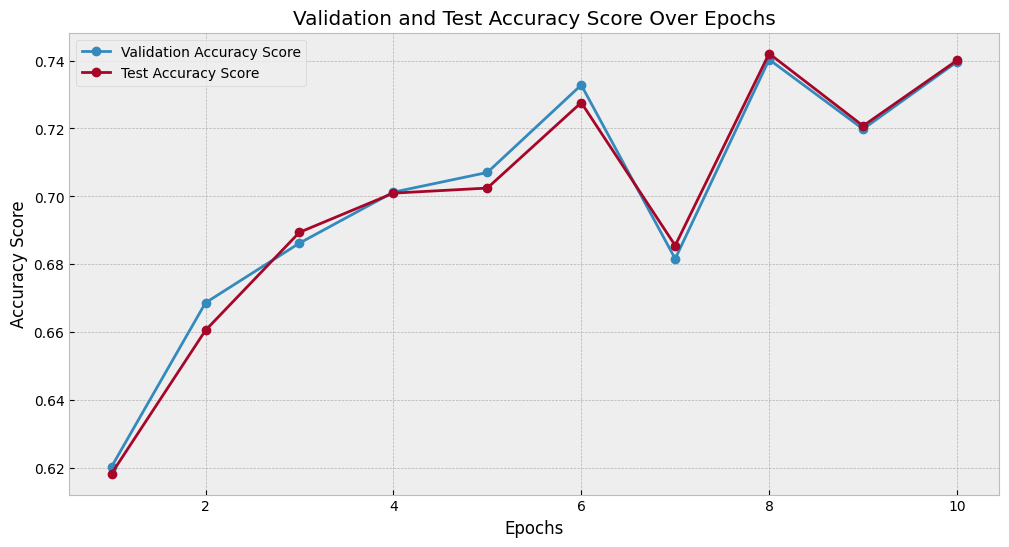

In [42]:
import matplotlib.pyplot as plt
import numpy as np

# Menggunakan range(1, num_epochs + 1) untuk sumbu x
epochs = range(1, num_epochs + 1)

# Plot training loss, validation loss, dan test loss
plt.figure(figsize=(12, 6))
plt.plot(epochs, train_losses, label='Training Loss', marker='o')
plt.plot(epochs, val_losses, label='Validation Loss', marker='o')
plt.plot(epochs, test_losses, label='Test Loss', marker='o')
plt.title('Training, Validation, and Test Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Plot F1 Score pada validasi dan test
plt.figure(figsize=(12, 6))
plt.plot(epochs, val_f1_scores, label='Validation F1 Score', marker='o')
plt.plot(epochs, test_f1_scores, label='Test F1 Score', marker='o')
plt.title('Validation and Test F1 Score Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('F1 Score')
plt.legend()
plt.grid(True)
plt.show()

# Plot Precision Score pada validasi dan test
plt.figure(figsize=(12, 6))
plt.plot(epochs, val_precisions, label='Validation Precision Score', marker='o')
plt.plot(epochs, test_precisions, label='Test Precision Score', marker='o')
plt.title('Validation and Test Precision Score Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Precision Score')
plt.legend()
plt.grid(True)
plt.show()

# Plot Recall Score pada validasi dan test
plt.figure(figsize=(12, 6))
plt.plot(epochs, val_recalls, label='Validation Recall Score', marker='o')
plt.plot(epochs, test_recalls, label='Test Recall Score', marker='o')
plt.title('Validation and Test Recall Score Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Recall Score')
plt.legend()
plt.grid(True)
plt.show()

# Plot Accuracy Score pada validasi dan test
plt.figure(figsize=(12, 6))
plt.plot(epochs, val_accuracies, label='Validation Accuracy Score', marker='o')
plt.plot(epochs, test_accuracies, label='Test Accuracy Score', marker='o')
plt.title('Validation and Test Accuracy Score Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy Score')
plt.legend()
plt.grid(True)
plt.show()


In [43]:
import pandas as pd

# Menggabungkan data dalam bentuk dictionary
data = {
    'Epoch': list(range(1, num_epochs + 1)),
    'Training Loss': train_losses,
    'Validation Loss': val_losses,
    'Test Loss': test_losses,
    'Validation F1 Score': val_f1_scores,
    'Validation Precision Score': val_precisions,
    'Validation Recall Score': val_recalls,
    'Validation Accuracy Score': val_accuracies,
    'Test F1 Score': test_f1_scores,
    'Test Precision Score': test_precisions,
    'Test Recall Score': test_recalls,
    'Test Accuracy Score': test_accuracies
}

# Buat DataFrame dari dictionary
df = pd.DataFrame(data)

# Tampilkan DataFrame
print(df)


   Epoch  Training Loss  Validation Loss  Test Loss  Validation F1 Score  \
0      1       0.962010         0.883746   0.884380             0.639311   
1      2       0.872197         0.790089   0.799038             0.691226   
2      3       0.821576         0.775099   0.781072             0.686711   
3      4       0.790654         0.771870   0.777549             0.712513   
4      5       0.767880         0.749318   0.757482             0.720250   
5      6       0.752152         0.731678   0.739974             0.728251   
6      7       0.741225         0.772209   0.777387             0.708279   
7      8       0.725443         0.698640   0.699541             0.726754   
8      9       0.718221         0.734375   0.739803             0.724976   
9     10       0.706262         0.699197   0.708581             0.732226   

   Validation Precision Score  Validation Recall Score  \
0                    0.710538                 0.620283   
1                    0.728866                 0

314/314 [==============================] - 4s 14ms/step


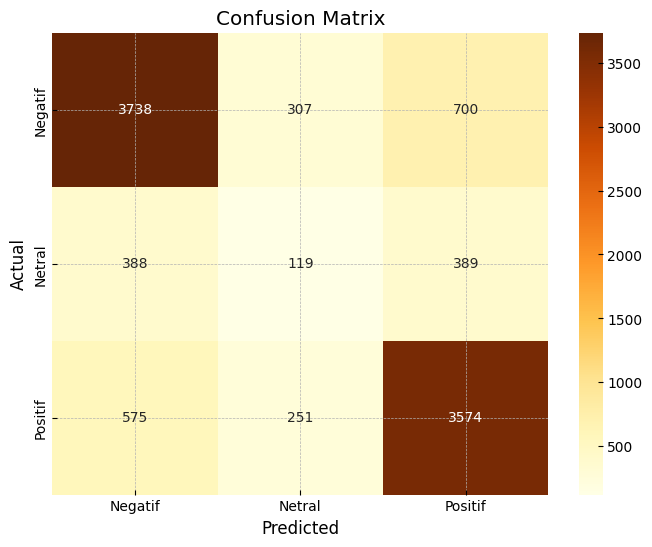

In [44]:
# Evaluasi model pada data uji
test_loss, test_accuracy = model.evaluate(word_seq_test, test_labels, verbose=0)
test_predictions = model.predict(word_seq_test)
test_predictions = np.argmax(test_predictions, axis=1)

# Membuat confusion matrix
confusion = confusion_matrix(np.argmax(test_labels, axis=1), test_predictions)

# Daftar label kelas
class_labels = ["Negatif", "Netral", "Positif"]

# Membuat heatmap dari confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion, annot=True, fmt='d', cmap='YlOrBr', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [45]:
# Tampilkan hasil prediksi dan label yang sebenarnya
for i in range(len(test_predictions)):
    print(f'Prediksi: {test_predictions[i]}, Label Sebenarnya: {np.argmax(test_labels[i])}')


Streaming output truncated to the last 5000 lines.
Prediksi: 2, Label Sebenarnya: 2
Prediksi: 2, Label Sebenarnya: 2
Prediksi: 0, Label Sebenarnya: 0
Prediksi: 2, Label Sebenarnya: 2
Prediksi: 2, Label Sebenarnya: 0
Prediksi: 2, Label Sebenarnya: 2
Prediksi: 0, Label Sebenarnya: 0
Prediksi: 2, Label Sebenarnya: 0
Prediksi: 2, Label Sebenarnya: 2
Prediksi: 0, Label Sebenarnya: 0
Prediksi: 2, Label Sebenarnya: 2
Prediksi: 0, Label Sebenarnya: 0
Prediksi: 2, Label Sebenarnya: 2
Prediksi: 2, Label Sebenarnya: 2
Prediksi: 0, Label Sebenarnya: 1
Prediksi: 0, Label Sebenarnya: 0
Prediksi: 2, Label Sebenarnya: 1
Prediksi: 0, Label Sebenarnya: 0
Prediksi: 0, Label Sebenarnya: 0
Prediksi: 1, Label Sebenarnya: 1
Prediksi: 2, Label Sebenarnya: 2
Prediksi: 0, Label Sebenarnya: 0
Prediksi: 2, Label Sebenarnya: 1
Prediksi: 0, Label Sebenarnya: 1
Prediksi: 2, Label Sebenarnya: 2
Prediksi: 0, Label Sebenarnya: 2
Prediksi: 0, Label Sebenarnya: 0
Prediksi: 0, Label Sebenarnya: 0
Prediksi: 0, Label Sebena

In [48]:
def predict_sentiment(model, tokenizer, text, max_seq_len):
    # Preprocess the input text
    cleaned_text = preprocess_text(text)
    tokenized_text = tokenizer.texts_to_sequences([cleaned_text])
    padded_text = sequence.pad_sequences(tokenized_text, maxlen=max_seq_len)

    # Make the sentiment prediction
    prediction = model.predict(padded_text)
    predicted_class = np.argmax(prediction)

    return predicted_class

text_to_predict = "Can't log in unless I already have an IG account? No option to create a basic IG account upon install? I'm out. Zuck sells all your data. He went to congress about it. He got caught. Not a fan of Musk but this should be a stand alone app. No need for IG. Btw..you can't delete Threads without deleting your IG all together."
predicted_sentiment = predict_sentiment(model, tokenizer, text_to_predict, max_seq_len)
print(f'Predicted Sentiment: {predicted_sentiment}')


1/1 [==============================] - 0s 24ms/step
Predicted Sentiment: 1
